In [1]:
__author__ = 'Aida Wofford and LVM team'
__version__ = '20250508'
__datasets__ = ['SDSS-V LVM SFrame (DRPVER=1.1.1, MJD=60191, EXPNUM=4297)']  
__keywords__ = ['Helix nebula']

# SDSS-V LVM DR19 "Helix nebula" tutorial
<p style="line-height: 1.5;"><b>Figure. </b>Digital Sky Survey image of the Helix nebula. We overlay the footprints of LVM's field of view and fibers. We highlight the central fiber in orange.</p>
<div style="width: 100%;">
    <img src="figures/helix_mjd60191_expnum4297_fib975.png" style="width: 100%;">
</div>

# Purpose
This tutorial focuses on data from LVM's science telescope. It teaches to:
<ol>
  <li>Access the fits file and display the list of Header Data Units</li>  
  <li>From the fits file, extract the slitmap table; and from this table, extract the data for fibers without known problems and load it into a data frame</li>  
  <li>Display a table with the slitmap</li>
  <li>Make a map of fibers without known issues with fiber-id labels</li>
  <li>Correct wavelength array for Doppler shift</li>
  <li>Obtain index of flux array corresponding to fiber of interest</li>
  <li>For a fiber of given ID, plot the reduced spectrum including the flux errors</li>
  <li>Zoom into spectral regions around H&alpha; and H&beta; in the observed and rest frames, note the presence of bad columns</li>
  <li>Note that some fibers capture bright stars</li>
  <li>Make maps of the emission within spectral windows around emission lines</li>
  <li>Make a composite RGB (red/green/blue) map that combines fluxes from three different spectral windows that capture emission lines</li>
  <li>Fit a single Gaussian to an emission line to obtain its flux</li>
  <li>Make an emission-line ratio map based on Gaussian fits to the lines</li>
</ol> 

# Import libraries

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit

from sdss_access import Access
access = Access(release='ipl-3', verbose=True)

# 1) Access the fits file and display the list of Header Data Units

In [3]:
# DOWNLOAD lvmSFrame file
access.remote()
drpver = '1.1.1'
kind = 'SFrame'
tileid = '11111'
mjd = 60191
expnum = 4297
access.add('lvm_frame', drpver = drpver, kind = kind, tileid = tileid, mjd = mjd, expnum = expnum)
access.set_stream()
access.commit()

# PATH to lvmSFrame file
path_to_data_file = access.full('lvm_frame', drpver = drpver, kind = kind, tileid = tileid, mjd = mjd, expnum = expnum)

# Open data file and print a summary of the Header Data Units
fits.info(path_to_data_file)

authentication for netloc=data.sdss5.org set for username=sdss5
rsync -Rin --out-format='%B%16l %t %f' "rsync://sdss5@dtn.sdss.org/ipl-3/spectro/lvm/redux/1.1.1/0011XX/11111/60191/lvmSFrame-00004297.fits*"
SDSS_ACCESS> Reducing the number of streams from 5 to 1, the number of download tasks.
SDSS_ACCESS> CREATE /var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/sdss_access/20250512_004
SDSS_ACCESS> streamlets added to /var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/sdss_access/20250512_004
SDSS_ACCESS> [background]$ 'rsync -avRKL --files-from=/var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/sdss_access/20250512_004/sdss_access_00.txt rsync://sdss5@dtn.sdss.org/ipl-3 /Users/jdonor/sas/ipl-3/'
SDSS_ACCESS> rsync stream 0 logging to /var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/sdss_access/20250512_004/sdss_access_00.log


Progress:   0%|                                                | 0/1 [00:00<?, ?files/s, n_files=1, n_streams=1]

SDSS_ACCESS> Done!
Filename: /Users/jdonor/sas/ipl-3/spectro/lvm/redux/1.1.1/0011XX/11111/60191/lvmSFrame-00004297.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     898   ()      
  1  FLUX          1 ImageHDU        20   (12401, 1944)   float32   
  2  IVAR          1 ImageHDU        20   (12401, 1944)   float32   
  3  MASK          1 ImageHDU        19   (12401, 1944)   uint8   
  4  WAVE          1 ImageHDU        19   (12401,)   float32   
  5  LSF           1 ImageHDU        20   (12401, 1944)   float32   
  6  SKY           1 ImageHDU        20   (12401, 1944)   float32   
  7  SKY_IVAR      1 ImageHDU        20   (12401, 1944)   float32   
  8  SLITMAP       1 BinTableHDU     58   1944R x 21C   [K, K, 3A, K, 8A, 5A, K, 4A, D, D, K, 6A, 8A, K, 17A, D, K, K, K, D, D]   


# 2) From the fits file, extract the slitmap table; and from this table, extract the data for fibers without known problems and load it into a data frame

In [4]:
def get_unmasked_data(path_to_data_file):
    '''
    purpose
        Obtain data for fibers without known issues. The fibers could still have unknown issues.
    inputs
        path_to_data_file: string, complete path to fits file
    outputs
        fibermap: table with fibermap (all fibers)
        wave: NumPy array with wavelengths (Angstrom units, includes gaps due to bad columns)
        flux: 2D NumPy array with flux arrays for each good fiber (erg/s/cm2/A, fluxes for bad columns are set to NaN)
        error: 2D NumPy array with flux errors (standard deviations) for each good fiber 
        df: filtered data frame excluding data for the bad fibers (erg/s/cm2/A)
    '''
    
    # Open data file and load data (including fibers with a mask) into a "Header Data Unit List object" called sframe
    sframe = fits.open(path_to_data_file)

    # Store slitmap table into variable fibermap
    fibermap = Table(sframe['SLITMAP'].data)

    # For the science telescope, find indices of fibers that are not masked
    indices_good_scitel_fibers = (fibermap['targettype']=='science') & (fibermap['fibstatus'] == 0)

    # Load the wavelengths into variable wave
    wave = sframe['WAVE'].data

    # Load the flux arrays of good fibers in variable flux
    flux = sframe['FLUX'].data[indices_good_scitel_fibers]

    # Load the inverse variace of good fibers in variable ivar
    # The variance is the square of the standard deviation
    # The flux errors are equal to the standard deviation and thus = 1/sqrt(ivar)
    ivar = sframe['IVAR'].data[indices_good_scitel_fibers]
    error = 1/np.sqrt(ivar)

    # Close sframe object
    sframe.close()

    # Create a data frame with the content of the good fibers
    df = fibermap[indices_good_scitel_fibers].to_pandas()
    
    return fibermap, wave, flux, error, df


In [5]:
fibermap, wave, flux, error, df = get_unmasked_data(path_to_data_file)

# 3) Display a table with the fiber map
<a href="https://sdss-wiki.atlassian.net/wiki/spaces/LVM/pages/627048457/LVM+DRP+User+Guide#Slitmap">Link to slit map documentation</a>

In [6]:
Table(fibermap)

fiberid,spectrographid,blockid,finblock,targettype,ifulabel,finifu,telescope,xpmm,ypmm,ringnum,orig_ifulabel,orig_slitlabel,finsector,fmap,ypix_b,ypix_r,ypix_z,fibstatus,ra,dec
int64,int64,str3,int64,str8,str5,int64,str4,float64,float64,int64,str6,str8,int64,str17,float64,int64,int64,int64,float64,float64
1,1,B1,1,SKY,SkyW3,1,SkyW,0.0,0.0,1,A3-1,S1B1-1,1,SkyW3-1:S1B1-1,4004.0,4015,4012,0,321.613,-44.54320000000001
2,1,B1,2,standard,Spec1,135,Spec,1.429,5.115,19,P1-1,S1B1-2,1,Spec1-1:S1B1-2,3998.0,4010,4007,0,0.04460363918612728,-0.1596550041287928
3,1,B1,3,science,Sci1,1,Sci,0.0,7.92,25,S1-1,S1B1-3,1,Sci1-1:S1B1-3,3993.0,4004,4001,0,337.4169474614286,-21.084344018449997
4,1,B1,4,science,Sci1,2,Sci,0.286,7.755,25,S1-2,S1B1-4,2,Sci1-2:S1B1-4,3987.0,3999,3995,0,337.42638153117906,-21.07898431939437
5,1,B1,5,science,Sci1,3,Sci,0.572,7.59,25,S1-3,S1B1-5,3,Sci1-3:S1B1-5,3981.0,3993,3990,0,337.43581492731073,-21.073624095271583
6,1,B1,6,science,Sci1,4,Sci,0.857,7.425,25,S1-4,S1B1-6,4,Sci1-4:S1B1-6,3976.0,3987,3984,0,337.4452142099591,-21.068264089182854
7,1,B1,7,science,Sci1,5,Sci,1.143,7.26,25,S1-5,S1B1-7,5,Sci1-5:S1B1-7,3970.0,3982,3978,0,337.45464625878174,-21.062902818356775
8,1,B1,8,science,Sci1,6,Sci,1.429,7.095,25,S1-6,S1B1-8,6,Sci1-6:S1B1-8,3965.0,3976,3973,0,337.46407763267024,-21.05754102404877
9,1,B1,9,science,Sci1,7,Sci,1.715,6.93,25,S1-7,S1B1-9,7,Sci1-7:S1B1-9,3959.0,3971,3967,0,337.47350833118605,-21.0521787067879


# 4) Make fiber map with fiber-id labels and central fiber highlighted

In [7]:
def fiber_map(fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width,
                    sym, facecolors, edgecolors,
                    xlabel, ylabel, df):
    '''
    purpose
        Plot fiber map where the axes are the RA [deg] and Dec [deg] and the RA decreases from left to right
    inputs
        fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width: scalars
        sym, facecolors, edgecolors: strings
        xlabel, ylabel: strings
        df: data frame, contains data for the good fibers
    outpus
        ax: ax object, single subplot
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))   

    # Set axis labels with controlled fontsize
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=tick_label_size)  # 'both' means x and y

    # Use the filtered data frame to create the plot
    ax.scatter(
        df["ra"],
        df["dec"], 
        marker=sym,
        facecolors=facecolors,         # No fill inside the marker
        edgecolors=edgecolors,          # Gray border
        s=marker_size,                     # Size of markers 
        linewidths=marker_width)             # Thickness of the border

    # Invert x-axis
    ax.invert_xaxis()

    # Automatically adjust the spacing of subplots
    fig.tight_layout()

    for i in range(len(df)):
    # Add id of each fiber
        ax.text(df["ra"][i], 
                df["dec"][i],
                df["fiberid"][i], 
                ha= "center",
                va="center",
                size=6)

    # Highlight central fiber
        if df["fiberid"][i] == 975:#central fiber
            ax.scatter(
            df["ra"][i],
            df["dec"][i], 
            marker=sym,
            facecolors=facecolors,         # No fill inside the marker
            edgecolors='orange',          # orange border
            s=marker_size,                     # Size of markers
            linewidths=marker_width)  
    
    return ax

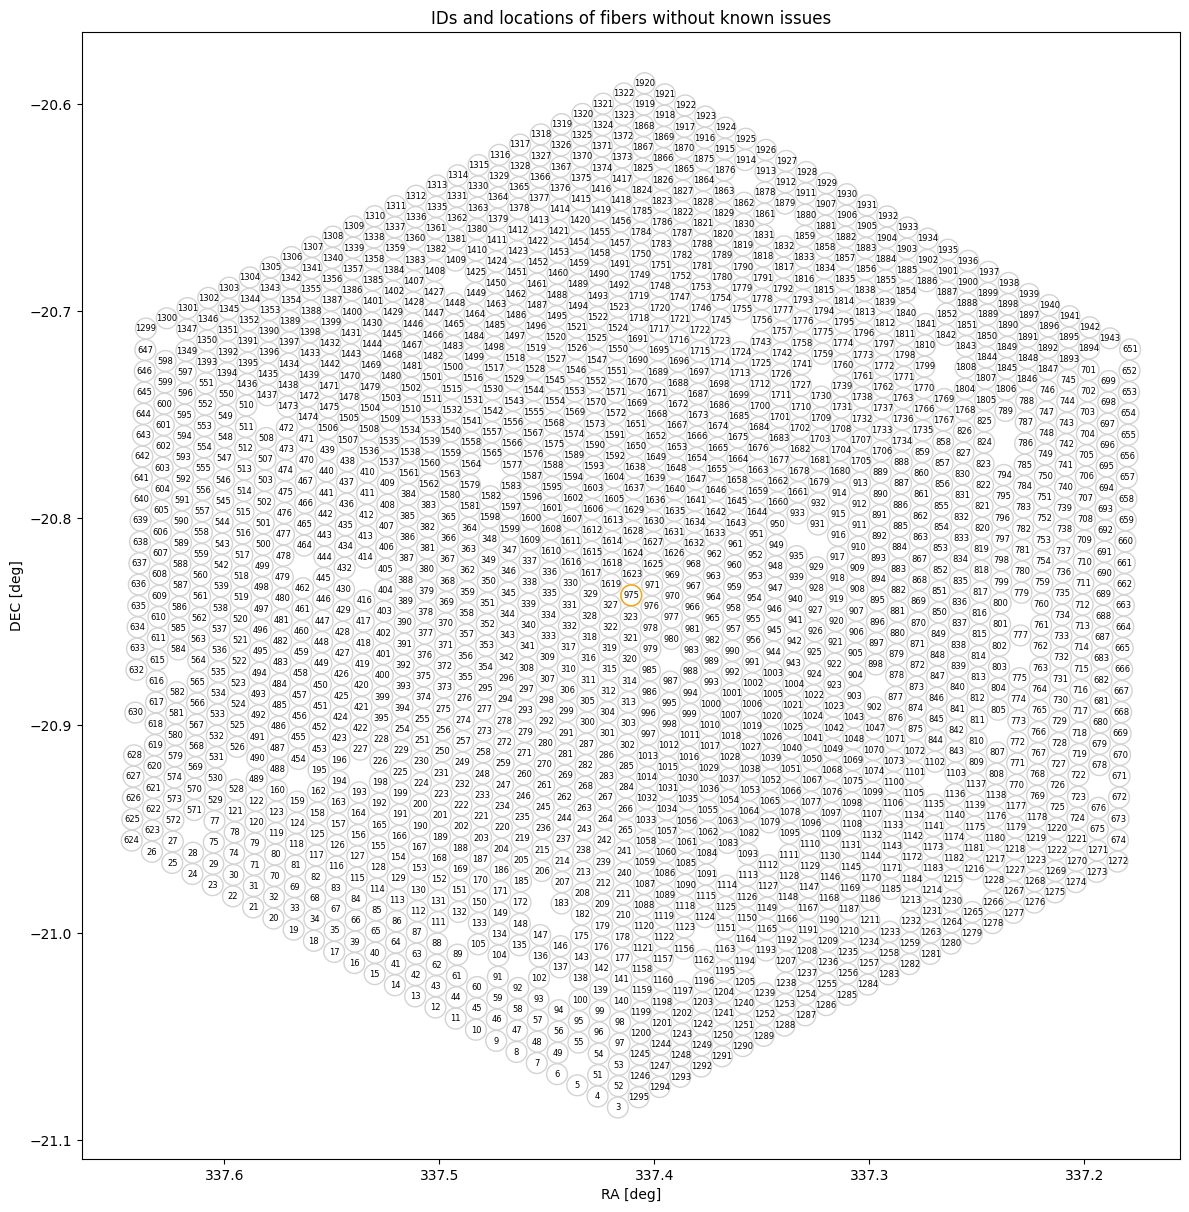

In [8]:
# Set the input values for the plot
fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width = 12, 12, 10 ,10, 225, 1
sym, facecolors, edgecolors = "o", "none", "lightgray"
xlabel, ylabel = 'RA [deg]', 'DEC [deg]'

# Plot fiber map
ax = fiber_map(fig_width, fig_height, fontsize, tick_label_size, marker_size, marker_width,
                     sym, facecolors, edgecolors,
                     xlabel, ylabel, df)

# Add title to plot
ax.set_title('IDs and locations of fibers without known issues')

# Save figure
#plt.savefig("fibermap.pdf")
plt.show()

# 5) Correct for Doppler shift

In [9]:
def correct_for_doppler_shift(z, xobs):
    '''
    purpose:
        Correct wavelength array for Doppler shift
    inputs:
        z: scalar, Doppler shift (negative for blueshifts)
        xobs: Numpy array, observed wavelength array
    outputs:
        xrest: Numpy array, rest-frame wavelenth array
    '''
    xrest = xobs / (1 + z)
    return xrest

In [10]:
# The Helix Nebula is in the Milky Way. It has a slight blueshift because it is moving towards us.
z = -0.00009

# Load observed-frame data into variable
xobs = wave

# Load rest-frame data into variable
xrest = correct_for_doppler_shift(z, xobs)

# 6) Obtain index of flux array corresponding to fiber of interest

In [11]:
def get_flux_index(fiber, df):
    '''
    purpose
        Obtain index to retreive flux array of given fiber
    inputs
        fiber: integer, fiber number
        df: data frame, contains data for the good fibers
    outpus
        flux_index: integer, flux index
    '''
    
    for i in range(len(df)):
        if df["fiberid"][i] == fiber:
            flux_index = i
            
    return flux_index

In [12]:
# Set id of fiber of interest
# In this example we pick the central fiber, #975
fiber = 975

# Call function to obtain flux index of fiber of interest
flux_index = get_flux_index(fiber, df)

# 7) For a fiber of given ID, plot the reduced spectrum including the flux errors

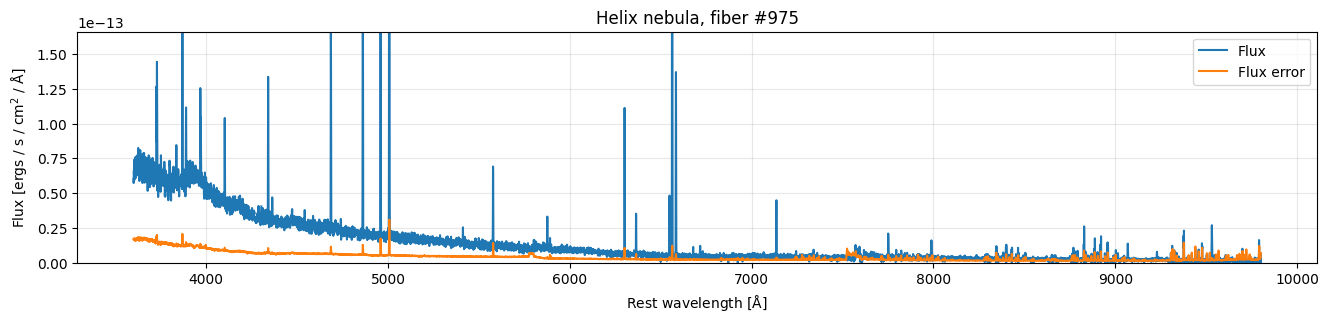

In [13]:
# Set id of fiber of interest
# In this example we pick the central fiber
fiber = 975

# Call the function to obtain the flux index for the fiber of interest
flux_index = get_flux_index(fiber, df)

# Select option for plot, i.e., if plot is in the observed- (xflag='Observed') or rest- (xflag='Rest') frame
xflag = 'Rest'

if xflag == 'Observed':
    wavelength = xobs
elif xflag == 'Rest':
    wavelength = xrest
else:
    wavelength = xobs

# Set plot parameters
fig, ax = plt.subplots(figsize=(16, 3))

# Plot
plt.plot(wavelength, flux[flux_index], label='Flux')
plt.plot(wavelength, error[flux_index], label='Flux error')
plt.title(f'Helix nebula, fiber #{fiber}')
plt.xlabel(f'{xflag} wavelength' + r' [${\rm \AA}$]')
plt.ylabel(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$]')
plt.ylim(0, max(flux[flux_index])/10)
plt.legend()
plt.grid(alpha=0.3)

# 8) Zoom into spectral regions around H&alpha; and H&beta; in the observed and rest frames, note the presence of a bad column

In [14]:
def plot_single_fiber_sp_win(wavelengths, fib_fluxes, fib_errors, minwave, maxwave, emission_lines, flag_xframe):
    '''
    purpose:
        Plot a portion of the spectrum with emission lines labelled
    inputs: 
        wavelengths: NumPy array, wavelengths
        fib_fluxes: NumPy array, fluxes for given fiber
        fib_errors: NumPy array, flux errors for given fiber
        minwave, maxwave: scalars, minimum and maximum wavelengths to be plotted
        lines: list of scalars, rest-frame air wavelengths of lines of interest
        flag_xframe: string, options are 'rest' or 'obs', used for x-axis label
    outputs:
        ax: object, single subplot
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize = (6, 3))
    plt.rcParams['font.size'] = 10 
    
    # Plot
    ax.plot(wavelengths, fib_fluxes, zorder=10, label='Flux')
    ax.plot(wavelengths, fib_errors, zorder=11, label='Flux error')
    ax.set_ylabel(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$]')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))  # Outside the plot to the right

    ax.grid(alpha = 0.3)
    
    # Set x-axis range
    ax.set_xlim(minwave, maxwave)   
    
    # Set y-axis range
    mask = (wavelengths >= minwave) & (wavelengths <= maxwave)
    ymax = max(fib_fluxes[mask])
    ax.set_ylim(0, 1.1*ymax)

    for label, wl in emission_lines.items():

        if label != 'Bad column':
            # Add vertical-dashed lines at the rest-frame air wavelengths of the emisison lines of interest
            ax.axvline(wl, color='gray', linestyle='--', zorder=0)

            # Shade area between vertical lines, 5 Ang away from each line of interest
            ax.axvspan(wl - 5, wl + 5, color='lightgray', alpha=0.3)
        
        # Label emission lines
        ax.text(wl, ymax * 0.95, label, rotation=90, color='black', verticalalignment='top')

    if xflag == 'Rest':
        ax.set_xlabel(r'Rest-frame wavelength [${\rm \AA}$]')
    elif xflag == 'Observed':
        ax.set_xlabel(r'Observed wavelength [${\rm \AA}$]')
        
    return ax

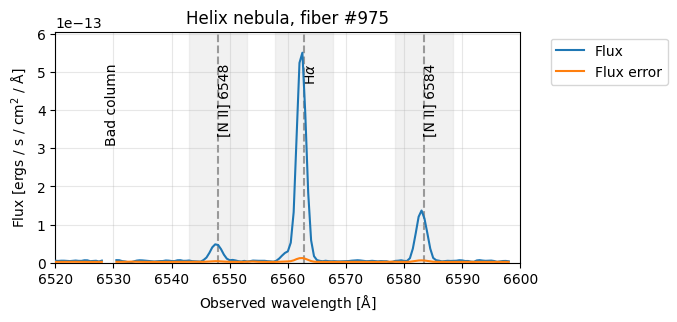

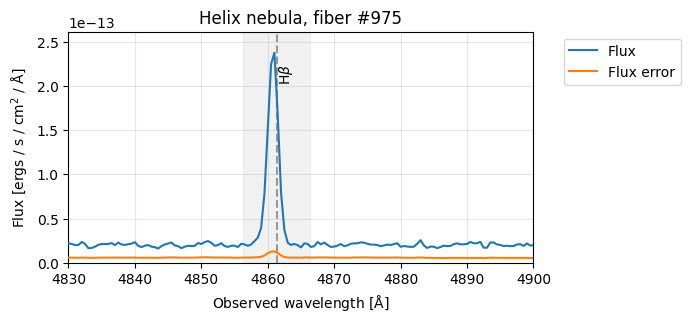

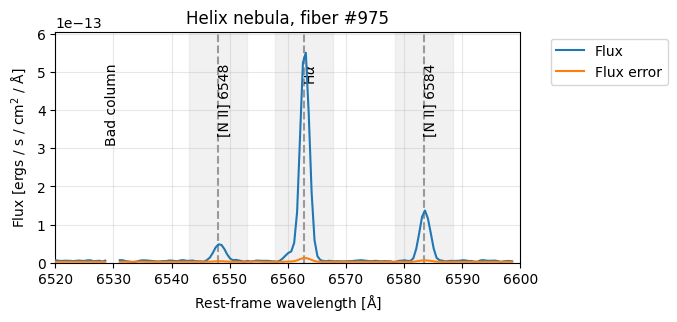

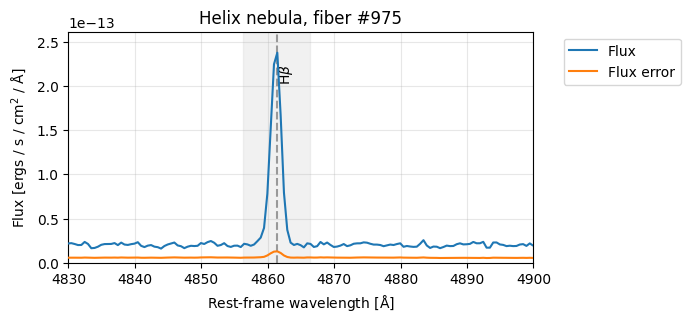

In [15]:
# Set id of fiber of interest
fiber = 975

# Call the function to obtain the flux index for the fiber of interest
flux_index = get_flux_index(fiber, df)

# Plot Halpha and Hbeta in the observed and rest frames
for ix in range(2):
    if ix == 0:
        xflag = 'Observed' # switch set to plot in observed frame
        wavelengths = xobs # observed frame
    elif ix == 1:
        # Set value of flag_xframe
        xflag = 'Rest' # switch set to plot in rest frame
        wavelengths = xrest # rest frame
        
    # Load fluxes and errors into variables
    flux_index = get_flux_index(fiber, df)
    fib_fluxes = flux[flux_index]
    fib_errors = error[flux_index]
    for iline in range(2):
        if iline == 0: # Create plot for region centered on Halpha + [N II]
            # NOTE: the gap at ~6530 Ang is due to a bad column
            minwave, maxwave = 6520, 6600 # Wavelength range to plot
            emission_lines = { # Dictionary of features of interest within spectral window
                'Bad column': 6528.5,
                '[N II] 6548': 6548.04,
                r'H$\alpha$': 6562.80,
                '[N II] 6584': 6583.46,
            }
        elif iline == 1: # Create plot for region centered on Hbeta
            minwave, maxwave = 4830, 4900 # Wavelength range to plot
            emission_lines = {r'H$\beta$': 4861.325}
        ax = plot_single_fiber_sp_win(wavelengths, fib_fluxes, fib_errors, minwave, maxwave, emission_lines, xflag)
        ax.set_title(f'Helix nebula, fiber #{fiber}')

# 9) Note that some fibers capture bright stars

<p style="line-height: 1.5;"><b>Figure. </b>Location of fiber 519 (highlighted with an <span style='color:orange'>orange</span> border), which is an example of a fiber that captures a bright star. We highlight this fiber with a <span style='color:magenta'>magenta</span> border in several plots of this notebook.</p>
<div style="width: 100%;">
    <img src="figures/helix_mjd60191_expnum4297_fib519.png" style="width: 100%;">
</div>

# 10) Make maps of the emission within spectral windows around emission lines

In [16]:
def sp_win_maps(lines):
    '''
    purpose
        Make a 3-panel plot where each panel shows the emission map of a different spectral window around an emission line
        Spectral windows rather than Gaussian fits to the lines are used
        The plots include the continuum emission and are not corrected for stellar absorption, background contamination, or reddening
        There is no filtering by the SNR
    inputs
        lines: dictionary (string, (scalar, scalar)) or 
        (ename, (ewave, ewidth)) <=> (ion, (air rest-frame wavelength, window half-width))
    '''
    
    ncols = 3
    nrows = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols,8), sharex=True, sharey=True)#, layout="constrained", subplot_kw=dict(projection=wcs))
    fig.suptitle(f"Helix nebula")
    plt.gca().invert_xaxis() # plt.gca gets the current axis object, .invert_xaxis inverts the x-axis so that RA increases right to left
    axs = axs.flatten() #transform 2D array to 1D array
    
    for i, (ename, (ewave, ewidth)) in enumerate(lines.items()):
        # Make mask for spectral window of interest
        mask = (ewave-ewidth <= wave) & (wave <= ewave+ewidth)

        # Load masked flux 2D array in variable z
        z = np.nanmean(flux[:, mask], axis=1) # all good fibers are included

        # A sqrt stretch is used
        norm = simple_norm(z, stretch="sqrt", min_percent=1, max_percent=99)

        # Plot title
        axs[i].set_title(f"{ename} {int(ewave)}")

        # Define color maps
        cmap_color=["Blues", "Greens", "Reds"]
        
        # Plot
        img = axs[i].scatter(x, y, s=65, lw=0, c=z, marker='o', cmap=cmap_color[i], norm=norm, edgecolors='none')
        
        # Add a colorbar with a different colormap for each image
        cbar = fig.colorbar(img, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label(r'Flux [ergs / s / cm$^2$ / ${\rm \AA}$]')

        # Call the function to obtain the flux index for a fiber contaminated with a star
        star_fiber = 519
        index_star_fiber = get_flux_index(star_fiber, df)

        #Highlight fiber with a bright star in magenta
        axs[i].scatter(
            df["ra"][index_star_fiber],
            df["dec"][index_star_fiber], 
            marker="o",
            facecolors='none',         # No fill inside the marker
            edgecolors='magenta',      # magenta border
            s=65,                      # Size of markers
            linewidths=1.5)            # Width of marker's border
        
    fig.supxlabel("RA (deg)")
    fig.supylabel("Dec (deg)")
 
    plt.tight_layout()


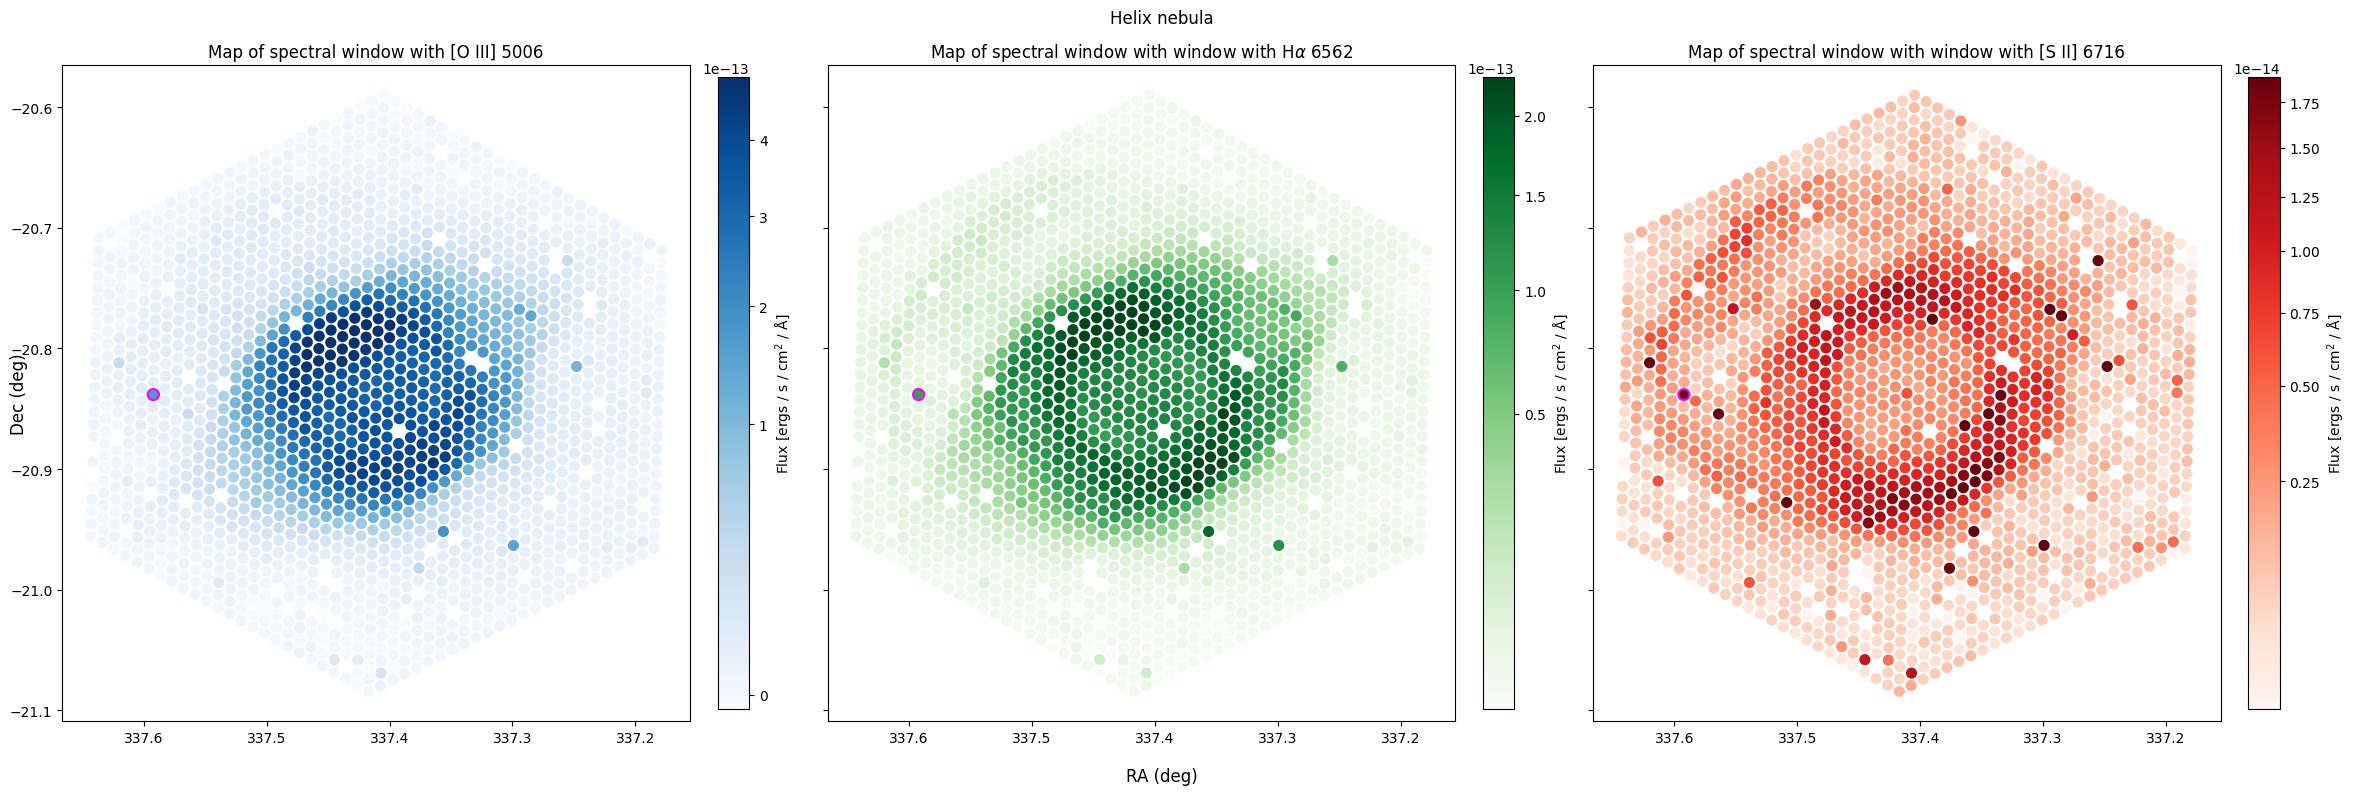

In [17]:
# Load fiber coordinates into variables
x = df['ra']
y = df['dec']

# Create a dictionary with some interesting lines
# The structure is key (rest-wavelength in air, half-size of the window in Angstroms)

lines = {
    "Map of spectral window with [O III]": (5006.843, 5), 
    r"Map of spectral window with window with H$\alpha$": (6562.80, 5), 
    "Map of spectral window with window with [S II]": (6716.44, 5) #[S II] doublet wavelengths are 6716.44, 6730.82. The first line is more luminous.
}

# Call the function to create the emission-line maps
# The maps include continuum emission within the spectral window
sp_win_maps(lines)

# 11) Make a composite RGB (red/green/blue) image

In [18]:
def rgb_map(lines):
    '''
    purpose:
        Create an RGB map using spectral windows that capture 3 given lines
    inputs:
        lines: dictionary (string, (scalar, scalar)) or 
        (ename, (ewave, ewidth)) <=> (ion, (air rest-frame wavelength, window half-width))
    outputs:
        rgb map
    '''

    for i, (ename, (ewave, ewidth)) in enumerate(lines.items()):

        mask = (ewave-ewidth <= wave)&(wave <= ewave+ewidth)
        if i == 0:
            # list of fluxes for each fiber in the window of the first line
            b_flux = np.nanmean(flux[:, mask], axis=1) 
        elif i == 1:
            # list of fluxes for each fiber in the window of the second line
            g_flux = np.nanmean(flux[:, mask], axis=1)
        else:
            # list of fluxes for each fiber in the window of the third line
            r_flux = np.nanmean(flux[:, mask], axis=1)


    # For each of the three spectral lines, ignore the 1% of the fibers with the faintest fluxes and the 1% of the fibers with the brightest fluxes.
    # There are 1754 good fibers and 1% of this number is 18 fibers.
    # Record the flux of the 19th faintest and 19th brightest fibers.
    min_r_flux = np.sort(r_flux)[18] 
    max_r_flux = np.sort(r_flux)[-18] 
    min_g_flux = np.sort(g_flux)[18] 
    max_g_flux = np.sort(g_flux)[-18] 
    min_b_flux = np.sort(b_flux)[18] 
    max_b_flux = np.sort(b_flux)[-18] 

    # Re-map flux range to values between 0 and 1 and and clip the fluxes of fibers that we are ignoring.
    # Values below min_flux are set to 0.
    # Values above max_flux are set to 1.
    # Values in between are mapped linearly onto the interval 0 to 1.
    r_norm = np.clip((r_flux - min_r_flux) / (max_r_flux - min_r_flux), 0, 1)
    g_norm = np.clip((g_flux - min_g_flux) / (max_g_flux - min_g_flux), 0, 1)
    b_norm = np.clip((b_flux - min_b_flux) / (max_b_flux - min_b_flux), 0, 1)

    # Apply a sqrt strech to the flux range
    # this makes faint signals more prominent
    r_norm = np.sqrt(r_norm)
    g_norm = np.sqrt(g_norm)
    b_norm = np.sqrt(b_norm)

    # Apply a sqrt strech a second time
    # this makes faint signals even more prominent
    #r_norm = np.sqrt(r_norm)
    #g_norm = np.sqrt(g_norm)
    #b_norm = np.sqrt(b_norm)

    # Combine into an (N, 3) color array
    colors = np.stack([r_norm, g_norm, b_norm], axis=1)

    # Set plot parameters and plot
    plt.figure(figsize=(6, 6))
    plt.title('Helix nebula\n'+r'R = [S II] 6717, G = H$\alpha$ 6563, B = [O III] 5007')
    for ifiber in range(len(b_flux)):
        plt.scatter(x[ifiber], y[ifiber], color=colors[ifiber], s=45, edgecolors='none')
    plt.gca().invert_xaxis() # plt.gca gets the current axis object, .invert_xaxis inverts the x-axis so that RA increases right to left
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")
    #plt.axis('equal')

    # Call the function to obtain the flux index for a fiber contaminated with a star
    star_fiber = 519
    index_star_fiber = get_flux_index(star_fiber, df)
    
    # Highlight fiber with star in magenta
    plt.scatter(
        df["ra"][index_star_fiber],
        df["dec"][index_star_fiber], 
        marker="o",
        facecolors='none',        # No fill inside the marker
        edgecolors='magenta',     # magenta border
        s=45,                     # Size of markers
        linewidths=1.5)

    plt.show()

    return

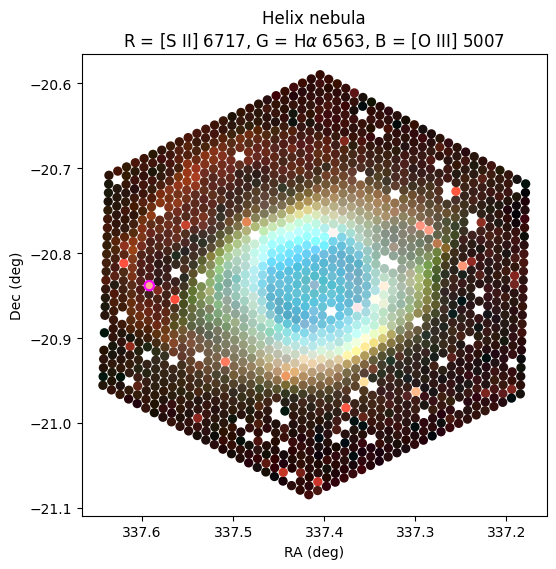

In [19]:
# Create a dictionary with some interesting lines
# The structure is key (rest-wavelength in air, half-size of the window in Angstroms)

lines = {
    "[O III]": (5006.843, 5), 
    r"H$\alpha$": (6562.80, 5), 
    "[S II]": (6716.44, 5) #Doublet wavelengths 6716.44, 6730.82, only take the first
}

# Create the rgb map
rgb_map(lines)

# 12) Fit a single Gaussian to an emission line to obtain its flux

In [20]:
def extract_portion_of_spectrum(wave_all, flux_all, minwave, maxwave):
    '''
    purpose
        Extract the portion of a spectrum after removing NaN values
        (note: flux=Nan when there is a gap in wavelegth coverage due to a bad pixel)
    inputs
        wave_all: NumPy array of scalar values, wavelength values
        flux_all: NumPy array of scalar values, fluxes at each wavelength 
        minwave, maxwave: scalars, wavelength limits for spectral window 
    outputs
        wave_subarray, flux_subarray: NumPy arrays with portion of spectrum
    '''

    # Remove NaN values
    not_nan_indices = np.where(~np.isnan(flux_all))[0]
    wave_all = wave_all[not_nan_indices]
    flux_all = flux_all[not_nan_indices]

    # Find the indices of wavelengths in the range of interest
    good_indices = (wave_all >= minwave) & (wave_all <= maxwave)

    # Extract the subarrays of interest
    wave_subarray = wave_all[good_indices]
    flux_subarray = flux_all[good_indices]

    return wave_subarray, flux_subarray

def subtract_continuum(wave_subarray, flux_subarray, exclude_regions):
    '''
    purpose
        Subtract continuum from flux array
    inputs
        wave_subarray: NumPy array of scalar values, wavelength values
        flux_subarray: NumPy array of scalar values, fluxes at each wavelength (note: flux=Nan for bad columns, i.e. gaps in wavelegth coverage)
        exclude_regions: NumPy array of scalar values, defines wavelength ranges to avoid due to the presence of emission or absorption lines to avoid
    outputs
        wave_continuum, flux_continuum: NumPy arrays of scalar values, wavelengths and fluxes used for the continuum fit
        flux_cont_sub: NumPy array of scalar values, continuum subtracted fluxes
    '''
    # Create a continuum mask with all data included
    continuum_mask = np.ones_like(wave_subarray, dtype=bool)

    # Exclude each line region from the mask
    for start, end in exclude_regions:
        # Update continuum_mask (&=) with wavelengths that do not satisfy the condition (~)
        continuum_mask &= ~((wave_subarray >= start) & (wave_subarray <= end))  
    
    # Apply continuum mask
    wave_continuum = wave_subarray[continuum_mask]
    flux_continuum = flux_subarray[continuum_mask]

    #Fit a line to the nearby continuum
    fit_coeffs = np.polyfit(wave_continuum, flux_continuum, deg=1)
    fit_line = np.polyval(fit_coeffs, wave_subarray)

    # Subtract continuum
    flux_cont_sub = flux_subarray - fit_line
    return wave_continuum, flux_continuum, fit_line, flux_cont_sub

def gaussian(x, amplitude, mean, sigma):
    '''
    purpose
        Evaluate an unormalized Gaussian function (area under curve = amplitude*sigma*sqrt(2*pi) at input value
    inputs
        x: input value(s), can be a scalar or NumPy array
        amplitude: scalar, height of the peak
        mean: scalar, center of the peak
        sigma: scalar, standard deviation
    outpus
        Gaussian function evaluated at input values
    '''
    return amplitude * np.exp(-((x - mean)**2) / (2 * sigma**2))

def gaussian_line_flux(wave_all, flux_all, minwave, maxwave, exclude_regions, wave_center):
    '''
    purpose
        Obtain the flux of an emission line via Gaussian fitting 
        Return some of the wavelength and flux arrays used in the process
        Return the array of model fluxes
    inputs
        wave_all: NumPy array of scalar values, wavelength values
        flux_all: NumPy array of scalar values, fluxes at each wavelength 
        minwave, maxwave: scalars, wavelength limits for spectral window 
        exclude_regions: NumPy array of scalar values, defines wavelength ranges to avoid due to the presence of emission or absorption lines to avoid
        wave_center: initial guess for the central wavelength of the Gaussian
    outputs 
        flux_all: NumPy array of scalar values, original flux array for the selected fiber
        wave_subarray: NumPy array of scalar values, wavelength values
        flux_subarray: NumPy array of scalar values, fluxes at each wavelength (note: flux=Nan for bad columns, i.e. gaps in wavelegth coverage)
        wave_continuum, flux_continuum: NumPy arrays of scalar values, wavelengths and fluxes used for the continuum fit
        fit_line: NumPy array of scalar values, linear fit to continuum
        flux_cont_sub: NumPy array of scalar values, continuum subtracted fluxes
        params: parameters of the Gaussian fit
        flux_density_model: NumPy array of scalar values, fit to the flux density (Gaussian fit)
        params: NumPy array of scalar values, parameters of Gaussian fit
    '''
    # Extract portion of spectrum
    wave_subarray, flux_subarray = extract_portion_of_spectrum(wave_all, flux_all, minwave, maxwave)

    # Subtract continuum
    wave_continuum, flux_continuum, fit_line, flux_cont_sub = subtract_continuum(wave_subarray, flux_subarray, exclude_regions)

    # Initial gaussian parameter guess: (amplitude, mean, sigma)
    p0 = [np.max(flux_cont_sub), wave_center, 1]

    try:
        # Fit the curve
        params, _ = curve_fit(gaussian, wave_subarray, flux_cont_sub, p0=p0)
        
        # Evaluate fitted Gaussian
        flux_density_model = gaussian(wave_subarray, *params)

        # Compute line flux (i.e., area under unormalized Gaussian)
        line_flux = np.sqrt(2*np.pi)*params[2]*params[0]
        
    except:
        
        print('Problem with line fitting')
    
    return flux_all, wave_subarray, flux_subarray, wave_continuum, flux_continuum, fit_line, flux_cont_sub, flux_density_model, line_flux, params

In [21]:
# Select if wavelengths will be in the observed- (xflag = 'Observed') or rest- (xflag = 'Rest') frame
xflag = 'Rest'

# Use xrest for wavelengths in the rest-frame and xobs for observed wavelengths
if xflag == 'Rest':
    wave_all = xrest
elif flab_wave == 'obs':
    wave_all = xobs

# Select rest-frame wavelength of line of interest
# wave_center = 4861.325 # Hbeta
wave_center = 6562.80 # Halpha

# For a given fiber, get all fluxes in the flux array
flux_index = get_flux_index(fiber, df)
flux_all = flux[flux_index]

# Define some variables based on the line selected
if wave_center == 4861.325: # Hb
    minwave, maxwave = 4830, 4900
    # Define spectral line regions to exclude
    exclude_regions = [(4861.325-5, 4861.325+5)]
elif wave_center == 6562.80: # Ha
    minwave, maxwave = 6520, 6600 
    # Select the width of half of the spectral window
    dx=5
    # Define spectral line regions to exclude
    exclude_regions = [(6548.04-dx, 6548.04+5),(6562.80-5, 6562.80+5),(6583.46-5, 6583.46+5)]  # Ha and [N II] doublet

flux_all, wave_subarray, flux_subarray, wave_continuum, flux_continuum, fit_line, flux_cont_sub, flux_density_model, line_flux, params = gaussian_line_flux(wave_all, flux_all,minwave, maxwave, exclude_regions, wave_center)

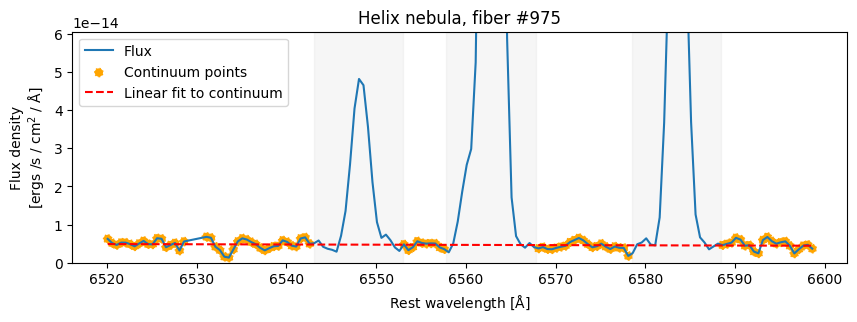

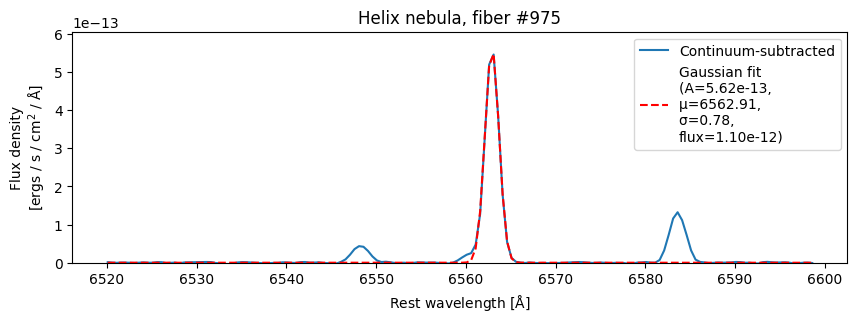

In [22]:
#--- Plot of fit to continuum

# Figure size
fig, ax = plt.subplots(figsize = (10, 3))

if xflag == 'Observed':
    plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
elif xflag == 'Rest':
    plt.xlabel(r'Rest wavelength [${\rm \AA}$]')
    
plt.ylabel('Flux density\n'+r'[ergs /s / cm$^2$ / ${\rm \AA}$]')
plt.title(f"Helix nebula, fiber #{fiber}")

# Axis ranges
#plt.xlim(minwave, maxwave)
plt.ylim(0, 1.1*max(flux_subarray)/10)


# Plot the result prior to removing the continuum
plt.plot(wave_subarray, flux_subarray, label='Flux')
plt.scatter(wave_continuum, flux_continuum, label='Continuum points', color='orange', linestyle=':')

# Fit to continuum
plt.plot(wave_subarray, fit_line, '--', label='Linear fit to continuum', color='red')

# Shade regions of interest
for start, end in exclude_regions:
    plt.axvspan(start, end, color='lightgray', alpha=0.2, zorder=0)


plt.legend()
plt.show()

#--- Plot of continuum subtracted flux density and Gaussian fit

fig, ax = plt.subplots(figsize = (10, 3))

# Title
plt.title(f"Helix nebula, fiber #{fiber}")

# x-axis label
if xflag == 'Observed':
    plt.xlabel(r'Observed wavelength [${\rm \AA}$]')
elif xflag == 'Rest':
    plt.xlabel(r'Rest wavelength [${\rm \AA}$]')

# y-axis label
plt.ylabel('Flux density\n'+r'[ergs / s / cm$^2$ / ${\rm \AA}$]')

# y-axis range
plt.ylim(0, 1.1*max(flux_subarray))

# Continuum-subtracted flux density
plt.plot(wave_subarray, flux_cont_sub, zorder=10, label='Continuum-subtracted')

# Gaussian fit
plt.plot(wave_subarray, 
         flux_density_model, 
         label=f'Gaussian fit\n(A={params[0]:.2e}, \nμ={params[1]:.2f}, \nσ={params[2]:.2f}, \nflux={np.sqrt(2*np.pi)*params[2]*params[0]:.2e})',
         color='red', zorder=11, linestyle='--')

# Legend
plt.legend()
plt.show()

# 13) Make an emission line ratio map, e.g., H&alpha;/H&beta;
NOTES: This map should be interpreted with <span style='color:red'>caution.</span> The map is uncorrected for stellar absorption and  background contamination. Some fibers are dominated by stellar emission. In addition, the map includes lines of low signal to noise ratio. Finally, recall that assuming that case B recombination holds, ratios lower than 2.8 are unphysical. In the example, ratios of less than 2 are shaded in black and the color-bar does not cover the full range of values.  


In [23]:
def single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions):
    '''
    purpose
        Find emission line flux by:
        - Subracting the continuum, 
        - Fitting a single unormalized Gaussian to the emission line, and
        - Finding the area under Gaussian = amplitude*sigma*sqrt(2*pi)
    inputs
        wavelengths: NumPy array of scalar values, wavelength values
        fluxes: NumPy array of scalar values, fluxes at each wavelength (note: flux=Nan for bad columns, i.e. regions with wavelength gaps)
        minwave, maxwave: scalars, wavelength limits for spectral window containing emission line to be measured
        x0: scalar, estimated wavelength of the line center
        exclude_regions: array or 2D array, wavelength ranges within spetral window to exclude when fitting the continuum
    outpus
        line_flux: emission line flux
    '''
    
    # Create a mask to extract wavelength range of interest
    subarr_mask = (wavelengths >= minwave) & (wavelengths <= maxwave)

    # Use mask to extract wavelength and flux subarrays of interest
    subarr_wave = wavelengths[subarr_mask]
    subarr_flux = fluxes[subarr_mask]
    
    # Define spectral windows to exclude

    # Create a continuum mask with all data included
    continuum_mask = np.ones_like(wavelengths, dtype=bool)

    # Exclude each line region from the mask
    for start, end in exclude_regions:
        # Update continuum_mask (&=) with wavelengths that do not satisfy the condition (~)
        continuum_mask &= ~((wavelengths >= start) & (wavelengths <= end))  
    
    # Apply continuum mask
    wave_continuum = wavelengths[continuum_mask]
    flux_continuum = fluxes[continuum_mask]

    #Fit a line to the nearby continuum
    fit_coeffs = np.polyfit(wave_continuum, flux_continuum, deg=1)
    fit_line = np.polyval(fit_coeffs, subarr_wave)

    # Subtract continuum
    flux_cont_sub = subarr_flux - fit_line

    # Initial parameter guess: (amplitude, mean, sigma)
    p0 = [np.max(flux_cont_sub), x0, 1]
    try:
        # Fit the curve
        params, _ = curve_fit(gaussian, subarr_wave, flux_cont_sub, p0=p0)
        
        # Evaluate fitted Gaussian
        fit_y = gaussian(subarr_wave, *params)
        line_flux = np.sqrt(2*np.pi)*params[2]*params[0]
    except:
        line_flux = np.nan
        
    return line_flux


def lvm_line_ratio_map(wave, flux, df):
    '''
    purpose
        Creates Ha/Hb line flux ratio map
        Uses Balmer line fluxes from Gaussian fitting of continuum subtracted spectra
        No stellar absorption or background subtraction are applied
        Only values between 2.7 and 2.9 are included in the color bar
        Values below 2.8 are not physical and can be due to 
        - fiber captures a bright star
        - stellar absorption under Hβ,
        - low signal-to-noise,
        - background contamination
    inputs
        wave, NumPy array, wavelengths
        flux, NumPy 2D arry, fluxes for each good fiber
        df: filtered data frame with good fibers
    outputs
        line ratio map
    '''
    
    # Set plot parameters
    fig, ax = plt.subplots(figsize=(12, 12))   

    # Set axis labels with controlled fontsize
    ax.set_xlabel('RA [deg]', fontsize=10)
    ax.set_ylabel('DEC [deg]', fontsize=10)

    # Set tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=10)  # 'both' means x and y

    # Initialize arrays
    flux_ratio = []
    x = []
    y = []
    eraseme=[] # for unphysical line ratios

    x = df['ra']
    y = df['dec']
    
    for i in range(len(df)):
        #x = np.append(x,df['ra'][i])
        #y = np.append(y,df['dec'][i])

        # Initialize values
        fha, fhb = -1, -1
        
        # For a given fiber, get wavelengths and fluxes
        wavelengths = wave
        flux_index = get_flux_index(df["fiberid"][i], df)
        fluxes = flux[flux_index] 

        # Remove nan values from wavelength and flux arrays
        not_nan_indices = np.where(~np.isnan(fluxes))[0]
        wavelengths = wavelengths[not_nan_indices]
        fluxes = fluxes[not_nan_indices]

        # Variable in Ang
        dx=5
        
        # Find Hb flux
        minwave, maxwave, x0 = 4830, 4900, 4861.325
        exclude_regions = [(4861.325-dx, 4861.325+dx)] # region(s) to be excluded from fit to continuum
        fhb = single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions)

        # Find Ha flux
        minwave, maxwave, x0 = 6520, 6600, 6562.80
        exclude_regions = [(6548.04-dx, 6548.04+dx),(6562.80-dx, 6562.80+dx),(6583.46-dx, 6583.46+dx)] # region(s) to be excluded from fit to continuum
        fha = single_gaussian_line_flux(wavelengths, fluxes, minwave, maxwave, x0, exclude_regions)

        # Filter fluxes. Realistic fluxes under case B recombination are >= 2.8
        if ((fha != np.nan) & (fhb != np.nan) & (fha / fhb > 2) & (fha / fhb <= 3)):
            flux_ratio = np.append(flux_ratio, fha / fhb)
        else:
            flux_ratio = np.append(flux_ratio, 2)
            eraseme = np.append(eraseme,i)

    img = plt.scatter(x, y, s=125, lw=0, c=flux_ratio, marker='o', cmap="viridis", edgecolors='none', vmin=2.7, vmax=2.9)
    
    erasex = [x[int(i)] for i in eraseme]
    erasey = [y[int(i)] for i in eraseme]
    
    plt.scatter(erasex, erasey, s=125, lw=0, facecolor='black', marker='o', edgecolors='none')
    
    # Add a colorbar for each image
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label(r'H$\alpha$/H$\beta$')

    #Highlight a fiber with a star in magenta
    # Call the function to obtain the flux index for the fiber of interest
    index_519 = get_flux_index(519, df)
    ax.scatter(
        df["ra"][index_519],
        df["dec"][index_519], 
        marker="o",
        facecolors='none',         # No fill inside the marker
        edgecolors='magenta',          # orange border
        s=125,                     # Size of markers
        linewidths=2)
    ax.invert_xaxis()
    return

[WARNING]: /var/folders/nd/01s30xjn2z1_lx_f3bqdbwt4nm074c/T/ipykernel_93514/165588657.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, subarr_wave, flux_cont_sub, p0=p0)



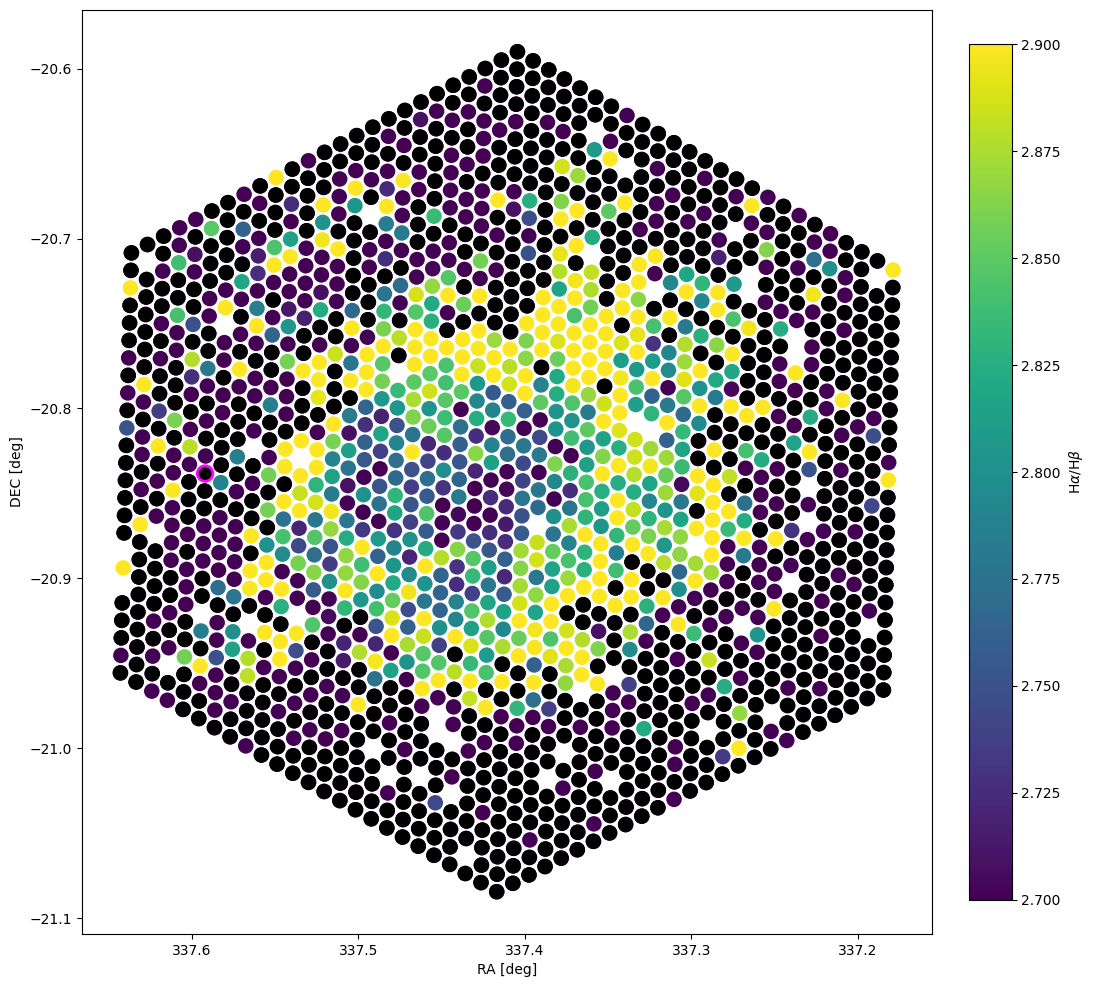

In [24]:
lvm_line_ratio_map(wave, flux, df)        